# Conditional GAN

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>

Edited by Dr. Chelsea Parlett-Pelleriti


**Date created:** 2021/07/13<br>
**Last modified:** 2023/11/20<br>
**Description:** Training a GAN conditioned on class labels to generate handwritten digits.

Generative Adversarial Networks (GANs) let us generate novel image data, video data,
or audio data from a random input. Typically, the random input is sampled
from a normal distribution, before going through a series of transformations that turn
it into something plausible (image, video, audio, etc.).

However, a simple [DCGAN](https://arxiv.org/abs/1511.06434) doesn't let us control
the appearance (e.g. class) of the samples we're generating. For instance,
with a GAN that generates MNIST handwritten digits, a simple DCGAN wouldn't let us
choose the class of digits we're generating.
To be able to control what we generate, we need to _condition_ the GAN output
on a semantic input, such as the class of an image.

In this example, we'll build a **Conditional GAN** that can generate MNIST handwritten
digits conditioned on a given class. Such a model can have various useful applications:

* let's say you are dealing with an
[imbalanced image dataset](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data),
and you'd like to gather more examples for the skewed class to balance the dataset.
Data collection can be a costly process on its own. You could instead train a Conditional GAN and use
it to generate novel images for the class that needs balancing.
* Since the generator learns to associate the generated samples with the class labels,
its representations can also be used for [other downstream tasks](https://arxiv.org/abs/1809.11096).

Following are the references used for developing this example:

* [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784)
* [Lecture on Conditional Generation from Coursera](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/conditional-generation-inputs-2OPrG)

If you need a refresher on GANs, you can refer to the "Generative adversarial networks"
section of
[this resource](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-12/r-3/232).

This example requires TensorFlow 2.5 or higher, as well as TensorFlow Docs, which can be
installed using the following command:

In [2]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


## Imports

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

# from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio
import pandas as pd

from plotnine import *

from tensorflow.keras.callbacks import CSVLogger

## Constants and hyperparameters

In [4]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

## Loading the MNIST dataset and preprocessing it

In [5]:
# We'll use all the available examples from both the training and test
# sets.
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

11490434/11490434 [==============================] - 0s 0us/step
Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


## Calculating the number of input channel for the generator and discriminator

In a regular (unconditional) GAN, we start by sampling noise (of some fixed
dimension) from a normal distribution. In our case, we also need to account
for the class labels. We will have to add the number of classes to
the input channels of the generator (noise input) as well as the discriminator
(generated image input).

In [6]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


## Creating the discriminator and generator

The model definitions (`discriminator`, `generator`, and `ConditionalGAN`) have been
adapted from [this example](https://keras.io/guides/customizing_what_happens_in_fit/).

In [7]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [8]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        6400      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 global_max_pooling2d (Glob  (None, 128)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                     

In [9]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6762)              939918    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6762)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 138)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       282752    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 128)       262272    
 Transpose)                                              

## Creating a `ConditionalGAN` model

In [10]:

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


## Training the Conditional GAN

In [12]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

csv_logger = CSVLogger('training.csv', append=False)

cond_gan.fit(dataset,
             epochs=20,
             callbacks = [csv_logger])

Epoch 1/20
1094/1094 [==============================] - 38s 29ms/step - g_loss: 1.4761 - d_loss: 0.4341
Epoch 2/20
1094/1094 [==============================] - 29s 27ms/step - g_loss: 1.3603 - d_loss: 0.4929
Epoch 3/20
1094/1094 [==============================] - 29s 26ms/step - g_loss: 1.5217 - d_loss: 0.4150
Epoch 4/20
1094/1094 [==============================] - 28s 26ms/step - g_loss: 4.7825 - d_loss: 0.1124
Epoch 5/20
1094/1094 [==============================] - 29s 27ms/step - g_loss: 2.5112 - d_loss: 0.1905
Epoch 6/20
1094/1094 [==============================] - 29s 27ms/step - g_loss: 1.3888 - d_loss: 0.5383
Epoch 7/20
1094/1094 [==============================] - 30s 27ms/step - g_loss: 1.0363 - d_loss: 0.6311
Epoch 8/20
1094/1094 [==============================] - 29s 27ms/step - g_loss: 0.8644 - d_loss: 0.6564
Epoch 9/20
1094/1094 [==============================] - 29s 26ms/step - g_loss: 0.8490 - d_loss: 0.6698
Epoch 10/20
1094/1094 [==============================] - 29s 26m

# Generating Digits

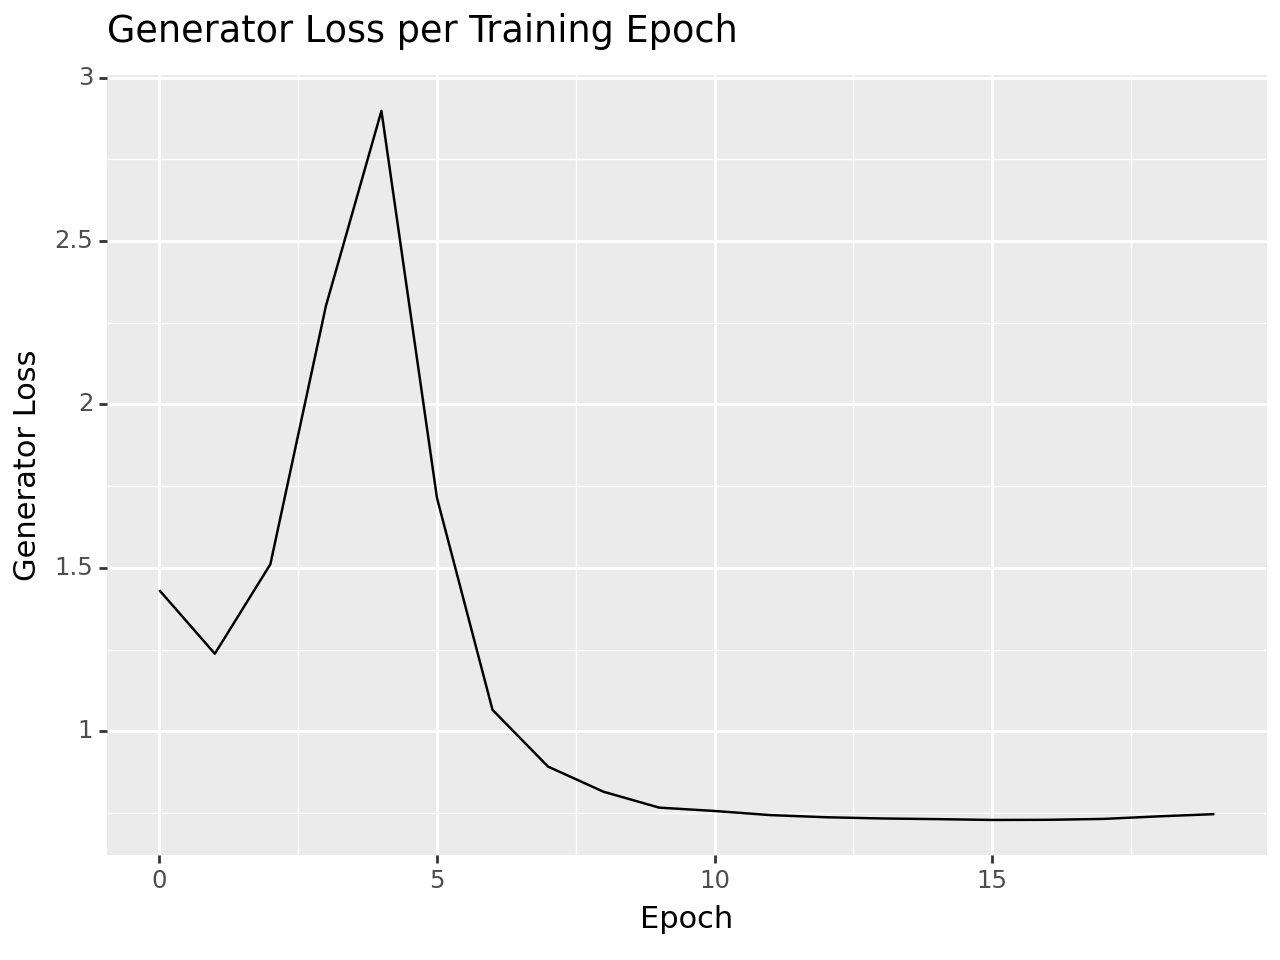

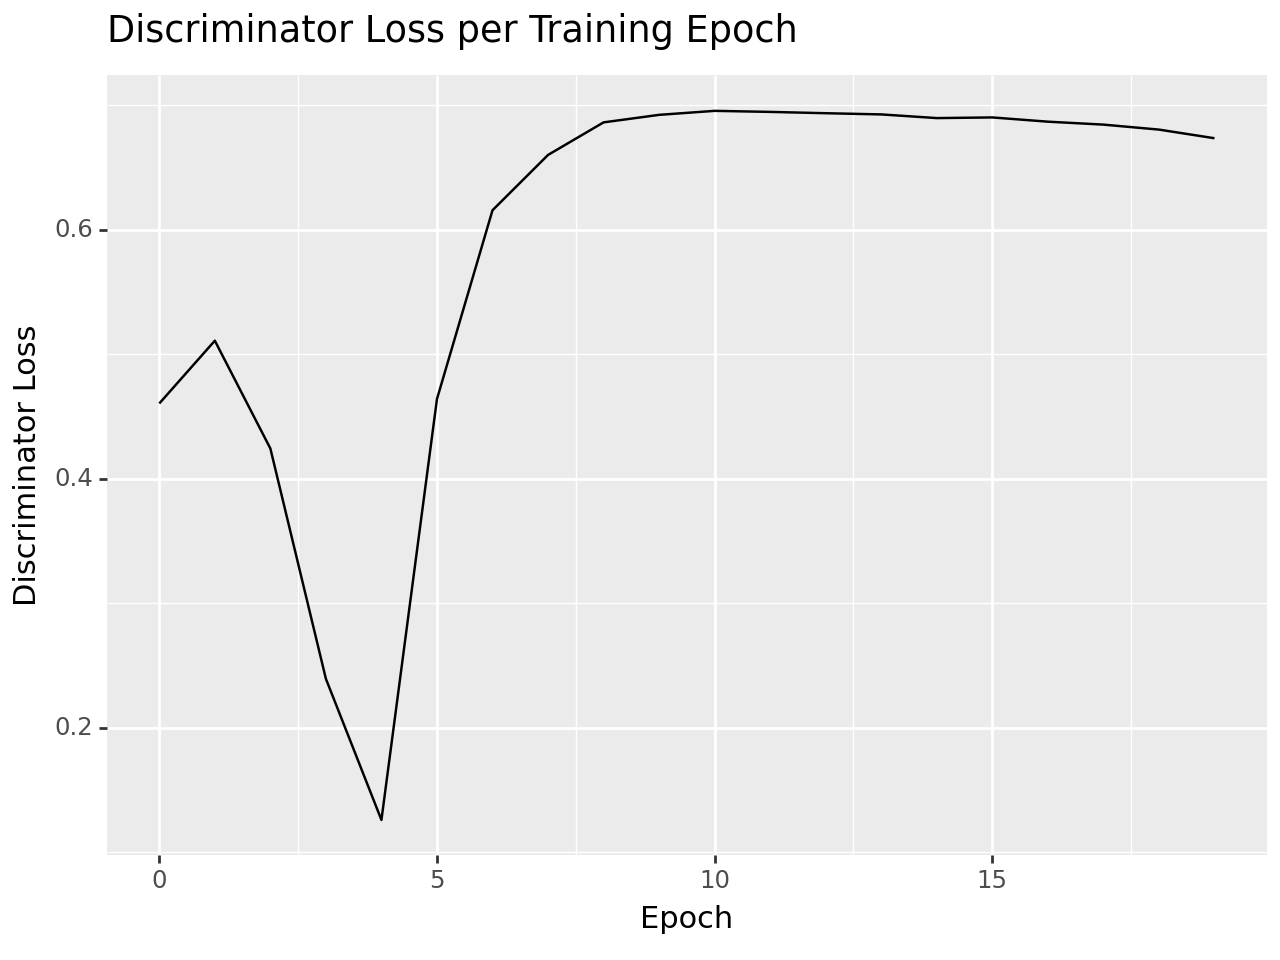

In [ ]:
# graph training.csv
df = pd.read_csv('training.csv')

# # color each line
plot1 = (ggplot(df, aes(x='epoch', y='g_loss'))
        + geom_line()
        + labs(x='Epoch', y='Generator Loss', title='Generator Loss per Training Epoch'))

plot2 = (ggplot(df, aes(x='epoch', y='d_loss'))
        + geom_line()
        + labs(x='Epoch', y='Discriminator Loss', title='Discriminator Loss per Training Epoch'))


print(plot1)
print(plot2)


In [14]:
from PIL import Image

# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator


In [15]:
# #### Re-run cell to get new image, change my_number to sample different digits ####

# # choose a number
# my_number = 4

# # Sample Noise

# # get noise array same shape as generator is expecting
# my_noise = tf.random.normal(shape=(1, generator_in_channels-10))

# # Sample Label

# # take number and one hot encode it
# my_label = keras.utils.to_categorical([my_number], num_classes)

# # convert this one-hot-encoded array into a 32-bit float
# my_label = tf.cast(my_label, tf.float32)

# # concatenate noise and label together
# my_input = tf.concat([my_noise, my_label], 1)


# # make prediction using trained generator
# fake_num = trained_gen.predict(my_input, verbose = False)

# # re-scale output
# fake_num *= 255.0

# # case to 8 bit int
# converted_image = fake_num.astype(np.uint8)

# # resize into an actual image shape
# converted_image = tf.image.resize(converted_image, (96, 96)).numpy().astype(np.uint8)

# # get rid of batch size dimension
# converted_image = np.squeeze(converted_image)

# # plot
# plt.imshow(converted_image, interpolation='nearest', cmap = 'gray')
# plt.axis('off') # turn off axes
# plt.show()

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "generator" is incompatible with the layer: expected shape=(None, 138), found shape=(None, 100)


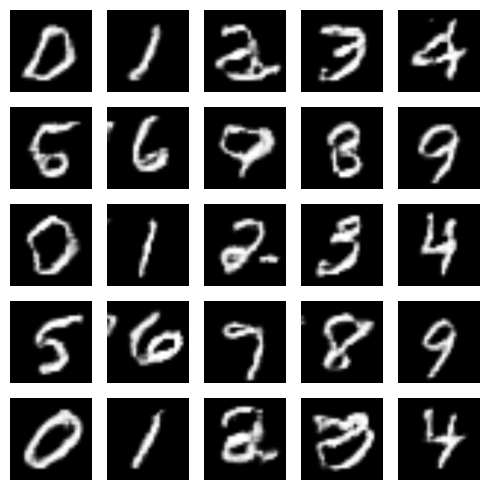

In [22]:
num_classes = 10
generator_in_channels = 138

# List to store generated images
images = []

for i in range(25):
    # Sample Noise
    my_noise = tf.random.normal(shape=(1, generator_in_channels - num_classes))

    # Sample Label
    my_number = i % 10  # This cycles through numbers 0-9 twice within the 25 iterations
    my_label = keras.utils.to_categorical([my_number], num_classes)
    my_label = tf.cast(my_label, tf.float32)

    # Concatenate noise and label together
    my_input = tf.concat([my_noise, my_label], axis=1)

    # Make prediction using trained generator
    fake_num = generator.predict(my_input, verbose=False)

    # Re-scale output to 0-255 and convert to 8-bit integer
    converted_image = (fake_num * 255.0).astype(np.uint8)

    # Resize into an actual image shape
    converted_image = tf.image.resize(converted_image, (96, 96)).numpy().astype(np.uint8)

    # Get rid of batch size dimension
    converted_image = np.squeeze(converted_image)

    # Append generated image to the list
    images.append(converted_image)

# Initialize plot
fig, axes = plt.subplots(5, 5, figsize=(5, 5))
for ax, img in zip(axes.flatten(), images):
    ax.imshow(img, cmap='gray')  # Display the image in grayscale
    ax.axis('off')  # Turn off the axes

plt.tight_layout()
plt.show()